<a href="https://colab.research.google.com/github/Rivallis/Notes/blob/master/JAX_tutorial_(winter_2022).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Based on Guodong Zhang's tutorials in CSC2541 Winter 2021.

## What is JAX?

[JAX](https://github.com/google/jax) = [autograd](https://github.com/HIPS/autograd) + [XLA](https://www.tensorflow.org/xla) = Numpy + Autodiff + XLA(Accelerated Linear Algebra)

JAX is a Python library which augments numpy and Python code with function transformations which make it trivial to perform operations common in machine learning programs. Concretely, this makes it simple to write standard Python/numpy code and immediately be able to


*   Compute the derivative of a function via a successor to autograd (`jax.grad`)
*   Compile and run your numpy programs on GPUs and TPUs via XLA by default. Just-in-time compile your own Python functions into XLA-optimized kernels using a one-function API (`jax.jit`)
*   Automagically vectorize a function, so that e.g. you can process a “batch” of data in parallel (`jax.vmap/jax.pmap`)


**Disclaimer: I'm by no mean an expert in JAX.**
- "A good programmer is typically the one who is good at googling".




In [ ]:
import jax
import jax.numpy as np
# Current convention is to import original numpy as "onp"
import numpy as onp

from jax import random

## Today's Focus
###1. [Autodiff](https://www.cs.toronto.edu/~rgrosse/courses/csc321_2018/slides/lec10.pdf)

- `jax.vjp` computes the vector-Jacobian product (aka reverse-mode autodiff) which is the key component of `jax.grad`
- `jax.jvp` computes the Jacobian-vector product (aka forward-mode autodiff) which is the key component of `jax.linearize`
- Using these two functions for many interesting matrix-vector product (e.g., Hessian-vector product)

###2. Example: Gauss-Newton Hessian-vector product in deep learning
- Gauss-Newton Hessian-vector product
- Using `jax.jit` to speed up training

#Autodiff

## `jax.vjp`

**A bit about math**

Mathematically, suppose we have a function $f: \mathbb{R}^n \rightarrow \mathbb{R}^m$, the Jacobian matrix of $f$ at a particular point $x$, denoted $J(x) \in \mathbb{R}^{m \times n}$, is a matrix:
$$J(x) =
\left(\begin{matrix}
\frac{\partial f_1}{\partial x_1} & \cdots & \frac{\partial f_1}{\partial x_n} \\
\vdots & \ddots & \vdots \\
\frac{\partial f_m}{\partial x_1} & \cdots & \frac{\partial f_m}{\partial x_n}
\end{matrix} \right)$$

You can think of it as a linear map $J(x): \mathbb{R}^n \rightarrow \mathbb{R}^m$ which maps $v$ to $J(x)v$.

What vector-Jacobian product does is to compute $v^TJ(x)$ or $J(x)^\top v$. `jax.vjp` is the api to compute the vector-Jacobian product in JAX with two arguments:
- first argument: a callable function $f$
- second argument: primal value at which point the Jacobian is evaluated (Should be either a tuple or a list of arguments)

It returns both $f(x)$ and a linear map $J(x)^\top: \mathbb{R}^m \rightarrow \mathbb{R}^n$ which map $v$ to $J^\top v$.

In [ ]:
f = lambda x: np.sum(3 * x ** 2)

y, vjp_fun = jax.vjp(f, np.ones((2, 2)))

key = random.PRNGKey(0)
key, subkey = random.split(key)
v = random.normal(subkey, y.shape)

# compute J^T v
vjp = vjp_fun(v)

The `jax.grad` function we used all the time is essentially a vector-Jacobian product.

In [ ]:
def my_grad(f, x):
  y, vjp_fn = jax.vjp(f, x)
  return vjp_fn(np.ones(y.shape))[0]

f = lambda x: np.sum(3 * x ** 2)
print("my_grad:\n {}".format(my_grad(f, np.ones((2, 2)))))
print("jax grad:\n {}".format(jax.grad(f)(np.ones((2, 2)))))

my_grad:
 [[6. 6.]
 [6. 6.]]
jax grad:
 [[6. 6.]
 [6. 6.]]


## `jax.jvp`

What Jacobian-vector product does is to compute $J(x)v$, which is the first-order term in Taylor expansion. Recall the Taylor expansion for a scalar function $f: \mathbb{R}^n \rightarrow \mathbb{R}$:
$$f(x) = f(x_0) + J(x_0)(x - x_0) + o(\| x - x_0 \|)$$

`jax.jvp` is the api to compute the Jacobian-vector product in JAX with three arguments:
- first argument: a callable function $f$
- second argument: primal value at which point the Jacobian is evaluated (Should be either a tuple or a list of arguments)
- third argument: tangent vector $v$

It returns both $f(x)$ and $J(x)v$.

In [ ]:
f = lambda x: np.sum(3 * x ** 2)
primal_value = np.ones((2, 2))
tangent_vector = np.ones((2, 2))
y, f_jvp = jax.jvp(f, (primal_value, ), (tangent_vector, ))
print(y, f_jvp)

12.0 24.0


### There is another function `jax.linearize` basically doing the same thing.

In [ ]:
y, f_linearized = jax.linearize(f, primal_value)
f_jvp_ = f_linearized(tangent_vector)
print(y, f_jvp_)

12.0 24.0


### Implementing `jax.jvp` using two `jax.vjp` (see this [thread](https://github.com/renmengye/tensorflow-forward-ad/issues/2))

- One important fact: for a linear operator $f(x) = Ax$, `vjp` returns $A^\top x$.
- In the first `vjp`, we get $J^\top v_\text{dummy}$ which is a linear operator with $A = J^\top$. In this step, we could use any $v_\text{dummy}$.
- In the second `vjp`, we get $Jv$.

In [ ]:
def my_jvp(f, x, v):
  ans, f_vjp = jax.vjp(f, x) # f_vjp returns a linear map J^T
  dummy_var = np.zeros_like(ans)
  _, f_vjp_vjp = jax.vjp(f_vjp, dummy_var) # f_vjp_vjp returns J
  return f_vjp_vjp((v,))[0]

f_jvp__ = my_jvp(f, primal_value, tangent_vector)
print(f_jvp__)

24.0


In [ ]:
%timeit jax.jvp(f, (primal_value, ), (tangent_vector, ))
%timeit f_linearized(tangent_vector)
%timeit my_jvp(f, primal_value, tangent_vector)

1000 loops, best of 5: 1.82 ms per loop
100 loops, best of 5: 16.1 ms per loop
100 loops, best of 5: 5.4 ms per loop


## Matrix-vector product

- Hessian-vector product $H(x)v$
- Gauss-Newton Hessian-vector product $J(x)^\top J(x)v$


### Hessian-vector product
In many cases, the Hessian matrix is extremely large, we could compute or store it. Fortunately, Hessian-vector product is typically enough for many things in machine learning.
- Computes $H^{-1}v$ in Newton method or influence function
- Computes the top eigenvalues of $H$ using power iteration or [Lanczos algorithm](https://arxiv.org/abs/1901.10159)

In [ ]:
def hvp(f, x, v):
  return jax.grad(lambda x: np.vdot(jax.grad(f)(x), v))(x)

That’s efficient, but we can do even better and save some memory by using forward-mode together with reverse-mode.

$$H(x) v = \partial^2 f(x) v = \partial g(x) v$$

All we need is applying `JVP` on gradient function $g$.

In [ ]:
def new_hvp(f, x, v):
  return jax.jvp(jax.grad(f), (x,), (v,))[1]

In [ ]:
f = lambda x: np.sum(3 * x ** 2)
primal_value = np.ones((2, 2))
tangent_vector = np.ones((2, 2))

print(hvp(f, primal_value, tangent_vector))
print(new_hvp(f, primal_value, tangent_vector))

[[6. 6.]
 [6. 6.]]
[[6. 6.]
 [6. 6.]]


In [ ]:
%timeit hvp(f, primal_value, tangent_vector)
%timeit new_hvp(f, primal_value, tangent_vector)

100 loops, best of 5: 8.9 ms per loop
100 loops, best of 5: 6.02 ms per loop


# Example: MNIST image classification using Gauss-Newton preconditioner

$J(x)^\top J(x)v$ Can be done by a `JVP` and a `VJP`. In training neural networks, we typically prefer Gauss-Newton matrix or Fisher matrix because they are positive semi-definite.

For training neural networks, we could use Gauss-newton updates:
$$ \theta_{t+1} = \theta_t - \eta G^{-1}g_t$$
To compute $G^{-1}g_t$, we solve the linear system $Gx = g_t$ using [conjugate gradient](https://www.cs.cmu.edu/~quake-papers/painless-conjugate-gradient.pdf).

**Caveat**: $G$ needs to be positive definite since conjugate gradient solves the linear system by minimizing $\frac{1}{2}x^\top G x - b x$.

In [ ]:
def conjugate_gradient(mvp, b, damping=0.01, max_iter=30):
  x = np.zeros_like(b)
  r = b
  p = r
  rdotr = r.dot(r)
  for i in range(1, max_iter):
    Ap = mvp(p) + damping * p
    v = rdotr / p.dot(Ap)
    x += v * p
    r -= v * Ap
    newrdotr = r.dot(r)
    mu = newrdotr / rdotr
    p = r + mu * p
    rdotr = newrdotr
  return x

##Training setup

In [ ]:
import time
import itertools
import scipy
import numpy.random as npr

import jax
import jax.numpy as np
from jax import jit, grad, random
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Tanh, LogSoftmax
from jax.flatten_util import ravel_pytree
from keras.datasets import mnist

rng = random.PRNGKey(0)

step_size = 0.1 # 0.003 for SGD, 0.3 for PSGD
num_epochs = 10
batch_size = 5000

init_random_params, predict = stax.serial(
    Dense(512), Tanh,
    Dense(512), Tanh,
    Dense(10))

def loss(params, batch):
  inputs, targets = batch
  preds = predict(params, inputs)
  one_hot_targets = jax.nn.one_hot(targets, 10)
  return np.mean(np.sum((preds - one_hot_targets) ** 2, axis=1))

def accuracy(params, batch):
  inputs, targets = batch
  predicted_class = np.argmax(predict(params, inputs), axis=1)
  return np.mean(predicted_class == targets)

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape(-1, 28 * 28)
test_images = test_images.reshape(-1, 28 * 28)

num_train = train_images.shape[0]
num_complete_batches, leftover = divmod(num_train, batch_size)
num_batches = num_complete_batches + bool(leftover)

def data_stream():
  rng = npr.RandomState(0)
  while True:
    perm = rng.permutation(num_train)
    for i in range(num_batches):
      batch_idx = perm[i * batch_size:(i + 1) * batch_size]
      yield train_images[batch_idx], train_labels[batch_idx]
batches = data_stream()

/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
/usr/local/lib/python3.7/dist-packages/jax/experimental/stax.py:30: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  FutureWarning)


11501568/11490434 [==============================] - 0s 0us/step


In [ ]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def train(epochs, update_fn):
    _, init_params = init_random_params(rng, (-1, 28 * 28))
    opt_state = opt_init(init_params)
    itercount = itertools.count()

    print("\nStarting training...")
    train_losses, train_accs, test_accs = [], [], []
    for epoch in tqdm(range(epochs)):
        start_time = time.time()
        for _ in range(num_batches):
            opt_state = update_fn(next(itercount), opt_state, next(batches))
        epoch_time = time.time() - start_time

        params = get_params(opt_state)
        train_losses.append(loss(params, (train_images, train_labels)))
        train_accs.append(accuracy(params, (train_images, train_labels)))
        test_accs.append(accuracy(params, (test_images, test_labels)))
    return train_losses, train_accs, test_accs

def plot_loss_accuracy(losses, train_acc, test_acc):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
    axes[0].plot(losses)
    axes[0].set_ylabel('Training loss')
    axes[0].set_xlabel('Epoch')
    axes[1].plot(train_acc, label='train')
    axes[1].plot(test_acc, label='test')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_xlabel('Epoch')
    plt.show()

##Plain SGD


Starting training...


100%|██████████| 20/20 [00:07<00:00,  2.73it/s]


Total training time = 10.64720106124878 s


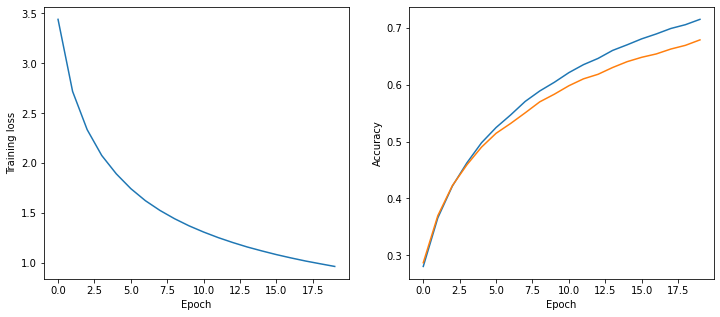

In [ ]:
step_size = 0.003
opt_init, opt_update, get_params = optimizers.sgd(step_size)

@jit
def update(i, opt_state, batch):
  params = get_params(opt_state)
  return opt_update(i, grad(loss)(params, batch), opt_state)

t0 = time.time()
train_losses, train_accs, test_accs = train(epochs=20, update_fn=update)
print(f'Total training time = {time.time() - t0} s')

plot_loss_accuracy(train_losses, train_accs, test_accs)

##With Gauss-Newton preconditioner


Starting training...


100%|██████████| 10/10 [00:35<00:00,  3.54s/it]


Total training time = 35.366393089294434 s


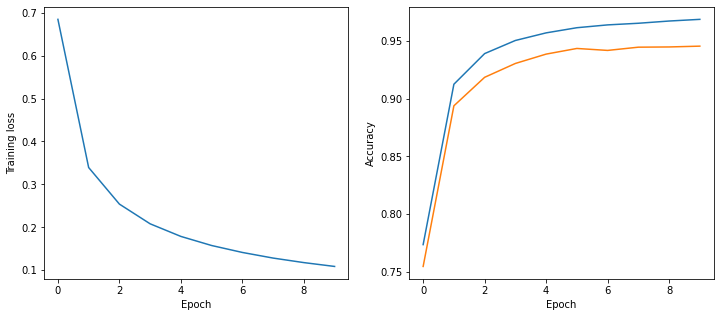

In [ ]:
step_size = 0.1
opt_init, opt_update, get_params = optimizers.sgd(step_size)

def gvp(params, v, batch):
  inputs, _ = batch
  f = lambda p: predict(p, inputs)
  _, unravel_fn = ravel_pytree(params)
  jvp = jax.jvp(f, [params], [unravel_fn(v)])[1]
  _, f_vjp = jax.vjp(f, params)
  gvp = f_vjp(jvp)[0]
  return ravel_pytree(gvp)[0] / inputs.shape[0]

@jit
def precon_update(i, opt_state, batch):
  params = get_params(opt_state)
  grads = grad(loss)(params, batch)
  # solve linear system using conjugate gradient
  _, unravel_fn = ravel_pytree(params)
  mvp = lambda v: gvp(params, v, batch)
  precon_grads = conjugate_gradient(mvp, ravel_pytree(grads)[0])
  precon_grads = unravel_fn(precon_grads)
  return opt_update(i, precon_grads, opt_state)

t0 = time.time()
train_losses, train_accs, test_accs = train(epochs=10, update_fn=precon_update)
print(f'Total training time = {time.time() - t0} s')
plot_loss_accuracy(train_losses, train_accs, test_accs)

##`jax.jit`

While carefully-written `numpy` code can be reasonably performant, for modern machine learning we want our code to run as fast as possible. JAX provides a JIT (just-in-time) compiler which takes a standard Python/`numpy` function and compiles it to run efficiently on an accelerator. Compiling a function also avoids the overhead of the Python interpreter, which helps whether or not you're using an accelerator. In total, `jax.jit` can dramatically speed-up your code with essentially no coding overhead - you just ask JAX to compile the function for you. Even our tiny neural network can see a pretty dramatic speedup when using `jax.jit`:

**Warning**: not all functions can be jit'ed (see [here](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#python-control-flow-+-JIT)).

In [ ]:
# Time the original gradient function
def f(x, y):
    return (x**1.5) * y + y ** 3

x0 = np.array(2.5)
y0 = np.array(3.3)

%timeit jax.grad(f)(x0, y0)

f_grad_jit = jax.jit(jax.grad(f))

# Run once to trigger JIT compilation
f_grad_jit(x0, y0)

%timeit f_grad_jit(x0, y0)

The slowest run took 114.89 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 3.36 ms per loop
10000 loops, best of 5: 42.2 µs per loop


###Use `jax.jit` to speed up the training above